In [84]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score

from sklearn.pipeline import Pipeline

In [47]:
X_train= pd.read_csv('X_train_imputed.csv')
y_train = pd.read_csv('y_train.csv')

X_test = pd.read_csv('X_test_imputed.csv')
y_test = pd.read_csv('y_test.csv')


In [49]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                15304 non-null  int64  
 1   h1n1_concern                 15304 non-null  float64
 2   h1n1_knowledge               15304 non-null  float64
 3   behavioral_antiviral_meds    15304 non-null  float64
 4   behavioral_avoidance         15304 non-null  float64
 5   behavioral_face_mask         15304 non-null  float64
 6   behavioral_wash_hands        15304 non-null  float64
 7   behavioral_large_gatherings  15304 non-null  float64
 8   behavioral_outside_home      15304 non-null  float64
 9   behavioral_touch_face        15304 non-null  float64
 10  doctor_recc_h1n1             15304 non-null  float64
 11  doctor_recc_seasonal         15304 non-null  float64
 12  chronic_med_condition        15304 non-null  float64
 13  child_under_6_mo

In [50]:
X_train=X_train.drop('respondent_id', axis=1)
y_train=y_train.drop('respondent_id', axis=1)

X_test=X_test.drop('respondent_id', axis=1)
y_test=y_test.drop('respondent_id', axis=1)


In [52]:
# Standard Scaler

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)


In [53]:
# Baseline model

baseline = MultiOutputClassifier(
    estimator=LogisticRegression(max_iter=1000 , penalty="l2", C=100)
)

baseline.fit(X_train_scaled, y_train)

preds = baseline.predict_proba(X_test_scaled)

In [38]:
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_test.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (6559, 2)


,h1n1_vaccine,seasonal_vaccine
0,0.000629,0.003189
1,0.314871,0.023000
2,0.046639,0.071547
3,0.000487,0.003798
4,0.085686,0.472536


In [40]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

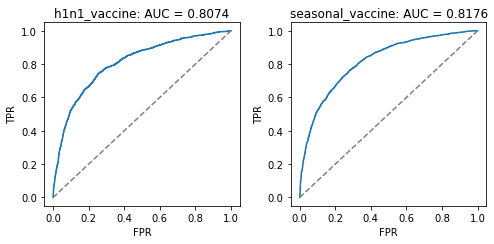

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_test['h1n1_vaccine'], 
    y_preds['h1n1_vaccine'], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_test['seasonal_vaccine'], 
    y_preds['seasonal_vaccine'], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

In [43]:
# the average AUC
roc_auc_score(y_test, y_preds)

0.8124900763280658

In [70]:
# One hot encoding for non-binary features 

non_binary = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective',
'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
'opinion_seas_risk', 'opinion_seas_sick_from_vacc']


# X_test data
nb_train = X_train[non_binary]

ohe = OneHotEncoder(drop='first', sparse=False)

dums = ohe.fit_transform(nb_train)

dums_df = pd.DataFrame(dums,
                       columns=ohe.get_feature_names(),
                       index=nb_train.index)




# X_test data

nb_test = X_test[non_binary]

dums_t = ohe.transform(nb_test)

dums_t_df = pd.DataFrame(dums_t,
                       columns=ohe.get_feature_names(),
                       index=nb_test.index)





In [77]:
# concat one hot encoded df and X 

# X_train data
X_train_1 = X_train.drop(non_binary, axis=1)

X_train_ohe = pd.concat([X_train_1, dums_df], axis=1)

# X_test data
X_test_1 = X_test.drop(non_binary, axis=1)

X_test_ohe = pd.concat([X_test_1, dums_t_df], axis=1)


In [80]:
# fit the baseline model to X_train_ohe 

baseline_1 = MultiOutputClassifier(
    estimator=LogisticRegression(max_iter=1000 , penalty="l2", C=100)
)


baseline_1.fit(X_train_ohe, y_train)

preds_1 = baseline_1.predict_proba(X_test_ohe)

y_preds_1 = pd.DataFrame(
    {
        "h1n1_vaccine": preds_1[0][:, 1],
        "seasonal_vaccine": preds_1[1][:, 1],
    },
    index = y_test.index
)
print("y_preds_1.shape:", y_preds_1.shape)
y_preds_1.head()

y_preds_1.shape: (6559, 2)


,h1n1_vaccine,seasonal_vaccine
0,0.094601,0.596491
1,0.532132,0.844448
2,0.538788,0.927631
3,0.089190,0.419641
4,0.540988,0.969596


In [86]:
cross_val_score(estimator=baseline_1, X=X_train_ohe, y=y_train, cv=5) 


array([0.68409017, 0.68572362, 0.65338125, 0.66481542, 0.66405229])

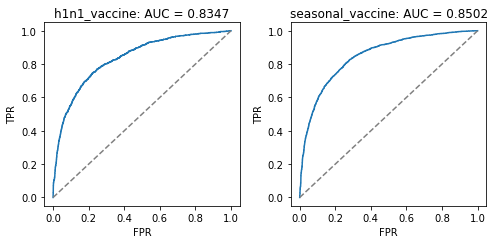

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_test['h1n1_vaccine'], 
    y_preds_1['h1n1_vaccine'], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_test['seasonal_vaccine'], 
    y_preds_1['seasonal_vaccine'], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

In [82]:
# the average AUC
roc_auc_score(y_test, y_preds_1)

0.8424443538507428